# **6. Bài toán luật kết hợp**

## **6.1. Mục tiêu**
* Lựa chọn các đặc trưng để tìm luật
* Điều chỉnh ngưỡng để đạt được các luật chính có ý nghĩa
* Áp dụng thuật toán Apriori để nhận biết luật mạnh
* Phân tích và vẽ biểu đồ chọn lọc luật mạnh

## **6.2. Import thư viện & Load dữ liệu**

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [21]:
df = pd.read_csv('hotel_bookings.csv')
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [22]:
df.tail()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
119385,City Hotel,0,23,2017,August,35,30,2,5,2,...,No Deposit,394.0,NaN,0,Transient,96.14,0,0,Check-Out,2017-09-06
119386,City Hotel,0,102,2017,August,35,31,2,5,3,...,No Deposit,9.0,NaN,0,Transient,225.43,0,2,Check-Out,2017-09-07
119387,City Hotel,0,34,2017,August,35,31,2,5,2,...,No Deposit,9.0,NaN,0,Transient,157.71,0,4,Check-Out,2017-09-07
119388,City Hotel,0,109,2017,August,35,31,2,5,2,...,No Deposit,89.0,NaN,0,Transient,104.40,0,0,Check-Out,2017-09-07
119389,City Hotel,0,205,2017,August,35,29,2,7,2,...,No Deposit,9.0,NaN,0,Transient,151.20,0,2,Check-Out,2017-09-07


In [23]:
df_transaction = df.copy()

# ---------------------------
# 1) Xử lý missing values
# ---------------------------
df_transaction['children'] = df_transaction['children'].fillna(0)
df_transaction['babies'] = df_transaction['babies'].fillna(0)
df_transaction['country'] = df_transaction['country'].fillna('UNK')
df_transaction['agent'] = df_transaction['agent'].fillna(0)
df_transaction['company'] = df_transaction['company'].fillna(0)

# -----------------------------
# 2) Loại bỏ dữ liệu không hợp lệ
# -----------------------------
df_transaction = df_transaction[(df_transaction['adults'] + df_transaction['children'] + df_transaction['babies']) > 0]
df_transaction = df_transaction[df_transaction['adr'] >= 0]

# -----------------------------
# 3) Feature Engineering
# -----------------------------
df_transaction['total_stay'] = df_transaction['stays_in_week_nights'] + df_transaction['stays_in_weekend_nights']
df_transaction['is_family_trip'] = (df_transaction['children'] + df_transaction['babies'] > 0).astype(int)

# Lead time bucket
df_transaction['lead_time_bucket'] = pd.cut(
    df_transaction['lead_time'],
    bins=[-1, 0, 30, 90, 180, 365, df_transaction['lead_time'].max()],
    labels=['0', '1-30','31-90','91-180','181-365','365+']
)

# ADR bucket (quantile)
df_transaction['adr_bucket'] = pd.qcut(
    df_transaction['adr'],
    q=5,
    duplicates='drop',
    labels=['A1','A2','A3','A4','A5']
)

# Stay bucket (fix total_stay=0)
df_transaction['stay_bucket'] = pd.cut(
    df_transaction['total_stay'],
    bins=[-1, 0, 1, 3, 7, 14, 100],
    labels=['0', '1', '2-3', '4-7', '8-14', '15+'],
    right=True
)

# Fix NaN sau bucket (tránh tạo item col=nan)
for c in ['lead_time_bucket', 'adr_bucket', 'stay_bucket']:
    df_transaction[c] = df_transaction[c].astype('object').fillna('UNK')

# -----------------------------
# 4) Chọn cột tạo item
# -----------------------------
cols_item = [
    'hotel','meal','market_segment','distribution_channel','customer_type',
    'deposit_type','reserved_room_type','is_repeated_guest',
    'is_family_trip','lead_time_bucket','adr_bucket','stay_bucket',
    'is_canceled'
]


In [24]:
df_transaction.shape

(119209, 37)

## **6.3. Tìm luật**

**Những dịch vụ hoặc loại phòng nào có xu hướng được đặt cùng nhau và có thể tạo thành các luật kết hợp mạnh?**

In [25]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# =========================
# 1. BUILD TRANSACTIONS (col=value)
# =========================
def build_transactions(df_in: pd.DataFrame, cols: list[str]) -> list[list[str]]:
    missing = [c for c in cols if c not in df_in.columns]
    if missing:
        raise ValueError(f"Thiếu cột trong cols_item: {missing}")

    tx = []
    for _, row in df_in[cols].iterrows():
        items = []
        for c in cols:
            v = row[c]
            if pd.isna(v):
                continue
            items.append(f"{c}={v}")
        tx.append(items)
    return tx

transactions = build_transactions(df_transaction, cols_item)
print(f"Transactions: {len(transactions):,}")
print("Example:", transactions[0][:10])

# =========================
# 2. ONE-HOT ENCODING
# =========================
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_hot = pd.DataFrame(te_ary, columns=te.columns_)

# =========================
# 3. APRIORI + RULES
# =========================
MIN_SUPPORT = 0.03
MIN_CONFIDENCE = 0.60
MIN_LIFT = 1.20
MAX_LEN = 3

freq = apriori(df_hot, min_support=MIN_SUPPORT, use_colnames=True, max_len=MAX_LEN)
freq = freq.sort_values("support", ascending=False).reset_index(drop=True)

rules = association_rules(freq, metric="confidence", min_threshold=MIN_CONFIDENCE)
rules = rules[rules["lift"] >= MIN_LIFT].copy()

# Làm đẹp hiển thị
rules["antecedents"] = rules["antecedents"].apply(lambda s: ", ".join(sorted(list(s))))
rules["consequents"] = rules["consequents"].apply(lambda s: ", ".join(sorted(list(s))))
rules = rules.sort_values(["lift", "confidence", "support"], ascending=False).reset_index(drop=True)

print(f"Frequent itemsets: {len(freq):,}")
print(f"Strong rules: {len(rules):,}")
print(rules.head(10)[["antecedents", "consequents", "support", "confidence", "lift"]])

# =========================
# 4. FILTER: luật tập trung dịch vụ/loại phòng
# =========================
FOCUS_COLS = {"hotel", "meal", "reserved_room_type"}

def has_focus(item_str: str, focus_cols: set[str]) -> bool:
    for it in [x.strip() for x in item_str.split(",")]:
        if "=" in it:
            col = it.split("=", 1)[0].strip()
            if col in focus_cols:
                return True
    return False

def only_focus_side(item_str: str, focus_cols: set[str]) -> bool:
    for it in [x.strip() for x in item_str.split(",")]:
        if "=" in it:
            col = it.split("=", 1)[0].strip()
            if col not in focus_cols:
                return False
    return True

# (A) any-side contains hotel/meal/room
mask_any = rules.apply(
    lambda r: has_focus(r["antecedents"], FOCUS_COLS) or has_focus(r["consequents"], FOCUS_COLS),
    axis=1
)
rules_focus_any = rules[mask_any].reset_index(drop=True)

# (B) both-side contains hotel/meal/room
mask_both = rules.apply(
    lambda r: has_focus(r["antecedents"], FOCUS_COLS) and has_focus(r["consequents"], FOCUS_COLS),
    axis=1
)
rules_focus_both = rules[mask_both].reset_index(drop=True)

# (C) "combo dịch vụ/phòng" đúng nghĩa: cả 2 vế CHỈ gồm hotel/meal/room + RHS 1 item
rules_service_combo = rules[
    rules["antecedents"].apply(lambda s: only_focus_side(s, FOCUS_COLS)) &
    rules["consequents"].apply(lambda s: only_focus_side(s, FOCUS_COLS))
].copy()
rules_service_combo = rules_service_combo[~rules_service_combo["consequents"].str.contains(",")].reset_index(drop=True)

print("\nFocus ANY:", len(rules_focus_any))
print("Focus BOTH:", len(rules_focus_both))
print("Service Combo (strict):", len(rules_service_combo))
print("\nTOP 15 Service Combo Rules:")
print(rules_service_combo.head(15)[["antecedents","consequents","support","confidence","lift"]].to_string(index=False))

# =========================
# 5. XUẤT FILE KẾT QUẢ
# =========================
freq.to_csv("frequent_itemsets.csv", index=False)
rules.to_csv("association_rules_all.csv", index=False)
rules_focus_any.to_csv("association_rules_focus_any.csv", index=False)
rules_focus_both.to_csv("association_rules_focus_both.csv", index=False)
rules_service_combo.to_csv("association_rules_service_combo.csv", index=False)

Transactions: 119,209
Example: ['hotel=Resort Hotel', 'meal=BB', 'market_segment=Direct', 'distribution_channel=Direct', 'customer_type=Transient', 'deposit_type=No Deposit', 'reserved_room_type=C', 'is_repeated_guest=0', 'is_family_trip=0', 'lead_time_bucket=181-365']
Frequent itemsets: 2,725
Strong rules: 845
                                         antecedents  \
0      distribution_channel=Corporate, is_canceled=0   
1                           market_segment=Corporate   
2                           market_segment=Corporate   
3  deposit_type=No Deposit, distribution_channel=...   
4  distribution_channel=Corporate, reserved_room_...   
5                           market_segment=Corporate   
6            distribution_channel=Corporate, meal=BB   
7                           market_segment=Corporate   
8  deposit_type=No Deposit, market_segment=Corporate   
9                     distribution_channel=Corporate   

                                         consequents   support  confid

## **6.4. Lọc và quan sát các luật mạnh**

In [26]:
rule = pd.read_csv('association_rules_service_combo.csv')
rule.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,reserved_room_type=E,hotel=Resort Hotel,0.054685,0.335931,0.041792,0.764228,2.274954,1.0,0.023422,2.816568,0.592851,0.119809,0.644958,0.444317
1,"meal=BB, reserved_room_type=E",hotel=Resort Hotel,0.042463,0.335931,0.031105,0.732517,2.180557,1.0,0.016840,2.482657,0.565411,0.089565,0.597206,0.412555
2,"meal=SC, reserved_room_type=A",hotel=City Hotel,0.087066,0.664069,0.086663,0.995375,1.498903,1.0,0.028845,72.638083,0.364589,0.130424,0.986233,0.562939
3,meal=SC,hotel=City Hotel,0.088492,0.664069,0.087862,0.992890,1.495161,1.0,0.029098,47.249817,0.363327,0.132184,0.978836,0.562600
4,"hotel=City Hotel, meal=SC",reserved_room_type=A,0.087862,0.720348,0.086663,0.986347,1.369264,1.0,0.023371,20.483021,0.295658,0.120107,0.951179,0.553327


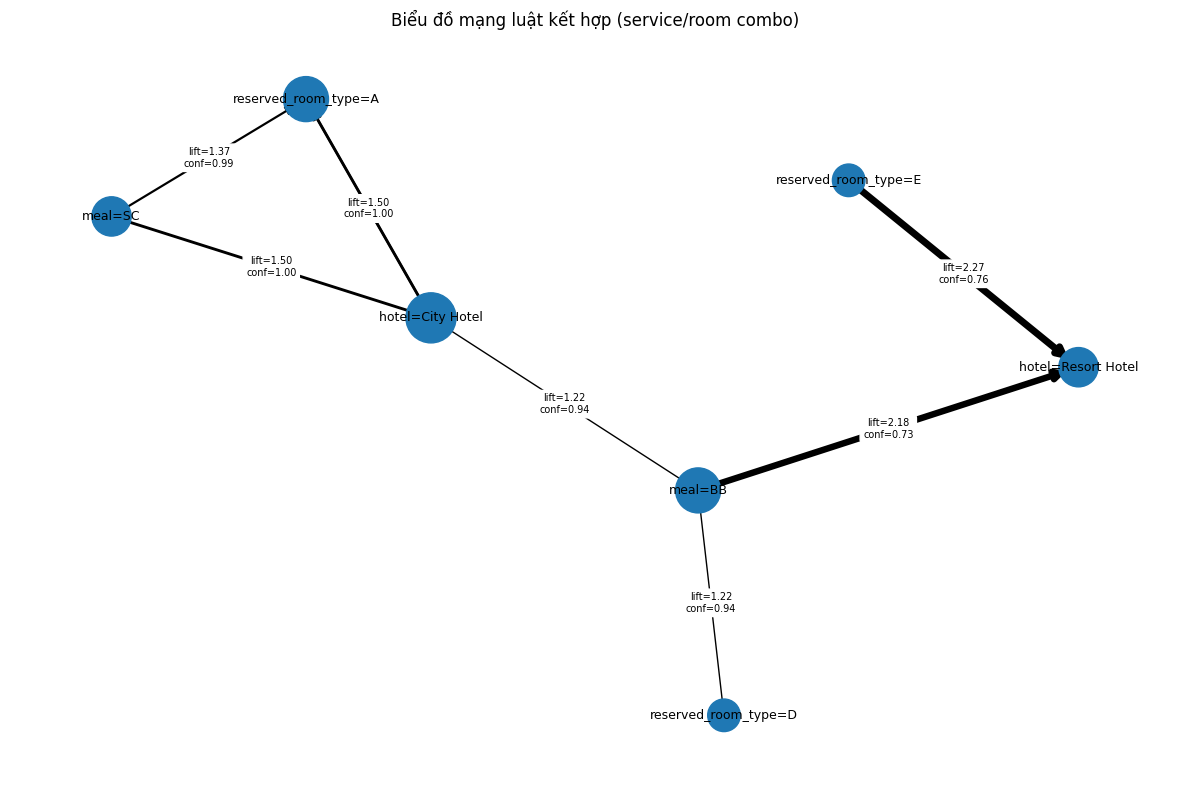

Saved: association_rules_network.png


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# =========================
# 1) ĐỌC FILE RULES
# =========================
RULES_PATH = "association_rules_service_combo.csv"
rules = pd.read_csv(RULES_PATH)

# =========================
# 2) HÀM TÁCH ITEM
# =========================
def split_items(s: str):
    # antecedents/consequents đang là chuỗi kiểu: "meal=SC, reserved_room_type=A"
    return [x.strip() for x in str(s).split(",") if x.strip()]

# =========================
# 3) TẠO ĐỒ THỊ (DIRECTED GRAPH)
# =========================
G = nx.DiGraph()

for _, r in rules.iterrows():
    ants = split_items(r["antecedents"])
    cons = split_items(r["consequents"])
    lift = float(r["lift"])
    conf = float(r["confidence"])
    sup  = float(r["support"])

    # Nếu antecedent có nhiều item -> tạo cạnh từ từng item sang consequent
    for a in ants:
        for c in cons:
            # nếu cạnh đã tồn tại thì giữ cạnh có lift lớn hơn
            if G.has_edge(a, c):
                if lift > G[a][c]["lift"]:
                    G[a][c].update({"lift": lift, "confidence": conf, "support": sup})
            else:
                G.add_edge(a, c, lift=lift, confidence=conf, support=sup)

# =========================
# 4) TÍNH KÍCH THƯỚC NODE & ĐỘ DÀY EDGE
# =========================
deg = dict(G.degree())
node_sizes = [300 + 250 * deg[n] for n in G.nodes()]  # node nhiều liên kết -> to hơn

lifts = [G[u][v]["lift"] for u, v in G.edges()]
min_l, max_l = min(lifts), max(lifts)

# scale độ dày cạnh theo lift
edge_widths = [
    1.0 + 4.0 * ((l - min_l) / (max_l - min_l) if max_l > min_l else 1.0)
    for l in lifts
]

# =========================
# 5) VẼ ĐỒ THỊ
# =========================
plt.figure(figsize=(12, 8))

# bố trí node
pos = nx.spring_layout(G, seed=42, k=0.9)

nx.draw_networkx_nodes(G, pos, node_size=node_sizes)
nx.draw_networkx_labels(G, pos, font_size=9)

nx.draw_networkx_edges(G, pos, width=edge_widths, arrows=True, arrowsize=14)

# nhãn cạnh: lift + conf
edge_labels = {
    (u, v): f"lift={G[u][v]['lift']:.2f}\nconf={G[u][v]['confidence']:.2f}"
    for u, v in G.edges()
}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7, rotate=False)

plt.title("Biểu đồ mạng luật kết hợp (service/room combo)")
plt.axis("off")
plt.tight_layout()

# =========================
# 6) LƯU ẢNH
# =========================
OUT_PATH = "association_rules_network.png"
plt.savefig(OUT_PATH, dpi=200)
plt.show()

print("Saved:", OUT_PATH)
